# Hierarchical analysis figures for GW190521 Implications paper

This notebook generates figures 11 and 12 for GW190521 Implications paper
__Properties and astrophysical implications of the 150 Msun binary black hole merger GW190521__ avaliable
through [ApjL](), [DCC](https://dcc.ligo.org/LIGO-P2000021/public) and [arXiv](https://arxiv.org/abs/2007.xxxx).

The data used in this notebook can be downloaded from the public DCC page [LIGO-P2000158](https://dcc.ligo.org/P2000158/public).


In [1]:
%matplotlib inline

# generic imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import trapz
import json
import os
import corner
import seaborn as sns

# suppress ignorable warnings
import warnings
warnings.simplefilter('ignore', category=UserWarning)

# ligo-specific imports
import bilby  # https://pypi.org/project/bilby/

In [2]:
# set up color map, fonts, etc
color_array = sns.color_palette("colorblind", n_colors=10, desat=.7)
cmap = sns.color_palette("RdBu_r", 26).as_hex()
cmap = cmap[:-1]

params = {
        # latex
        'text.usetex': True,
        # fonts
        'font.family': 'serif', 

        # figure and axes
        'figure.figsize': (14,7),
        'figure.titlesize': 35, 
        'axes.grid': False, 
        'axes.titlesize':20,
        #'axes.labelweight': 'bold', 
        'axes.labelsize': 40,

        # tick markers
        'xtick.direction': 'in', 
        'ytick.direction': 'in', 
        'xtick.labelsize': 16,
        'ytick.labelsize': 16, 
        'xtick.major.size': 10.0,
        'ytick.major.size': 10.0,
        'xtick.minor.size': 3.0,
        'ytick.minor.size': 3.0,

        # legend
        'legend.fontsize': 20,
        'legend.frameon': False,
        #'legend.framealpha':1.0,

        # colors
        'image.cmap': 'viridis',

        # saving figures
        'savefig.dpi': 300
        }

plt.rcParams.update(params)
plt.rcParams['font.serif'] = ['Computer Modern', 'Times New Roman']
plt.rcParams['font.family'] = ['serif', 'STIXGeneral']
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
plt.rcParams.update({'font.size': 22})

In [3]:
#---------------------
# plotting functions
#---------------------

def set_ticks(data,axes):
    fontsize=14
    N = len(data.T)
    cols = np.array([i + N*np.array(range(N)) for i in range(N) ])
    for ii,col in enumerate(cols):
        tick_labels, major_ticks, minor_ticks = get_ticks(data.T[ii])

        for jj in range(ii,N):
            axes[col[jj]].set_xticks(major_ticks)
            #axes[col[jj]].set_xticks(minor_ticks,minor=True)
            if jj == N-1: axes[col[jj]].set_xticklabels(tick_labels,fontsize=fontsize)
                
    for ii, row in enumerate(cols.T[1:]):
        tick_labels, major_ticks, minor_ticks = get_ticks(data.T[ii+1])
        for jj in range(ii+1):
            #print(jj)
            axes[row[jj]].set_yticks(major_ticks)
            #axes[row[jj]].set_yticks(minor_ticks,minor=True)
            if jj==0: axes[row[jj]].set_yticklabels(tick_labels,fontsize=fontsize)


def get_ticks(d):
    min_tick = int(round(min(d)))-1
    max_tick = int(round(max(d)))+1
    
    major_ticks = list(range(min_tick,max_tick))
    
    if len(major_ticks)>10:
        major_ticks = [major_ticks[i] for i in range(len(major_ticks)) if i % 3 == 0]

    elif len(major_ticks)>7:
        major_ticks = [major_ticks[i] for i in range(len(major_ticks)) if i % 2 == 0]
        
    tick_labels = ['$10^{'+str(tick)+'}$' for tick in major_ticks]
    minor_ticks=[]
    for tick in major_ticks:
        minor_ticks.extend([np.log10(i*10**tick) for i in range(2,10)])
    
    return tick_labels, major_ticks, minor_ticks


def getCL(Z,CL):
    zf = Z.flatten()
    zsort = np.argsort(zf)[::-1]
    levels=[]
    for cl in CL:
        zsum = 0
        zlast = 0
        j=0
        while zsum/np.sum(zf)<=CL:
            max_i = zsort[j]
            j+=1
            zlast=zf[max_i]
            zsum+=zf[max_i]
        levels.append(zlast)
    return levels                                  

# Relative Rates Plot

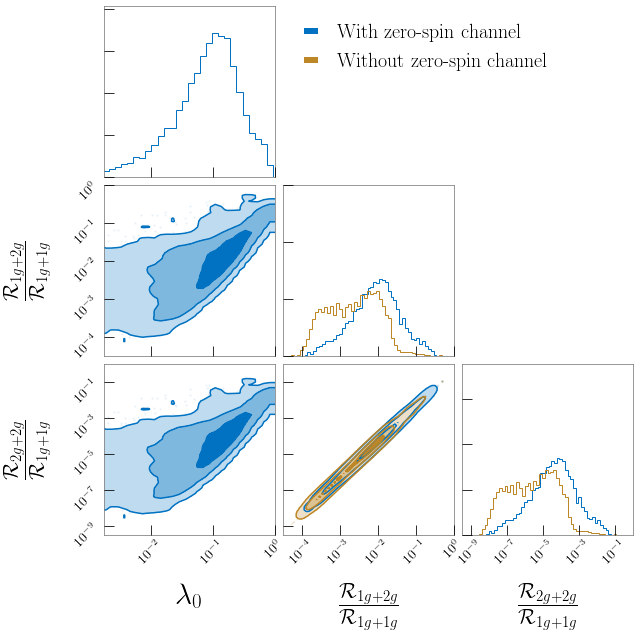

In [4]:
#Load in result files
rdir = 'GW190521_Implications_figure_data/hierarchical_data/'
result = bilby.core.result.read_in_result(rdir+'gwtc1_plus_NRSur/gauss_result.json')
result_no = bilby.core.result.read_in_result(rdir+'gwtc1_plus_no_zero_spin_NRSur/gauss_result.json')
gamma1_5 = result.posterior['branching_ratio_1_5'].values
gamma2 = result.posterior['branching_ratio_2'].values
delta_chi = result.posterior['delta_chi'].values
gamma1_5_no = result_no.posterior['branching_ratio_1_5'].values
gamma2_no = result_no.posterior['branching_ratio_2'].values

#For non-zero-spin runs, delta_chi is zero, which will mess up the plot ranges. 
#Load in the with-zero-spin posterior, we'll delete those lines later
delta_chi_no = result.posterior.sample(len(gamma2_no),replace=True)['delta_chi'].values

#We want to plot in log
data = np.array([np.log10(delta_chi),np.log10(gamma1_5), np.log10(gamma2)]).T
data_no = np.array([np.log10(delta_chi_no),np.log10(gamma1_5_no), np.log10(gamma2_no),]).T

labels = [r'$\lambda_{0}$',r'$\frac{\mathcal{R}_{1g+2g}}{\mathcal{R}_{1g+1g}}$',r'$\frac{\mathcal{R}_{2g+2g}}{\mathcal{R}_{1g+1g}}$']
labels_no = [r'$\lambda_{0}$',r'$\frac{\mathcal{R}_{1g+2g}}{\mathcal{R}_{1g+1g}}$',r'$\frac{\mathcal{R}_{2g+2g}}{\mathcal{R}_{1g+1g}}$']

plot_parameter_keys = ['branching_ratio_1_5','branching_ratio_2']

kwargs = dict(labels=labels,
            bins=50, smooth=0.9, label_kwargs=dict(fontsize=30),
            title_kwargs=dict(fontsize=20), color='#0072C1',
            truth_color='tab:orange', quantiles=None,
            levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
            plot_density=False, plot_datapoints=True, fill_contours=True,
            max_n_ticks=5)
#Plot with-zero-spin results
fig = corner.corner(data, **kwargs,hist_kwargs=dict(density=True,label='With zero-spin'))
kwargs['color'] = color_array[1]
kwargs['labels'] = labels_no
#Plot without-zero-spin results
no =corner.corner(data_no,**kwargs,hist_kwargs=dict(density=True,label='Without zero-spin'),fig=fig)

#Delete all points associated with without-zero-spin delta_chi
axes = fig.get_axes()
axes[3].lines[1].remove()
for coll in axes[3].collections[-8:]:
    coll.remove()
axes[6].lines[1].remove()
for coll in axes[6].collections[-8:]:
    coll.remove()
axes[0].patches[1].remove()
#Manually set ticks
set_ticks(data,axes)

lines=[]
#Create legend
lines.append(matplotlib.lines.Line2D([0], [0], color='#0072C1'))
lines.append(matplotlib.lines.Line2D([0], [0], color=color_array[1]))
labels = ['With zero-spin channel','Without zero-spin channel']
axes[1].legend(lines,labels,loc=2)

#Set plot limits
dchi_min = -2.75
dchi_max = 0
r15_min = -4.5
r15_max = 0
r2_min = -9.5
r2_max = 0
#dchi
axes[0].set_xlim(dchi_min,dchi_max)
axes[3].set_xlim(dchi_min,dchi_max)
axes[6].set_xlim(dchi_min,dchi_max)
#r15
axes[3].set_ylim(r15_min,r15_max)
axes[4].set_xlim(r15_min,r15_max)
axes[7].set_xlim(r15_min,r15_max)

axes[6].set_ylim(r2_min,r2_max)
axes[7].set_ylim(r2_min,r2_max)
axes[8].set_xlim(r2_min,r2_max)

axes[4].set_ylim(0,1.5)
axes[8].set_ylim(0,0.75)

axes

fig.set_figheight(9)
fig.set_figwidth(9)
filename = 'GW190521_Implications_Figures_pdf/relative_rates.pdf'
fig.savefig(filename,dpi=200)
fig.show()



# Bayes Factors Plot


In [5]:
# process BF vs m,a with contours - NRSur

event = 'GW190521'
result = 'gwtc1_plus_no_zero_spin_NRSur'
#Load PE samples
with open(os.path.join(rdir,result,'full_pe_samples.json'),'r') as f:
    posteriors = json.load(f)
    
posterior = posteriors[event][-1]['final_samples']
m_post = posterior['mass_1']
a_post = posterior['a_1']
ma_post = [m_post,a_post]

#Create 2D KDE over M1, A1
kde_post = stats.gaussian_kde(ma_post)

#load ppds
with open(os.path.join(rdir,result,'gauss_ppds.json'),'r') as f:
    ppds = json.load(f)

#Create grid to evaluate kdes on
a1s = a2s = ppds['a1s']
m1s = ppds['m1s']
M,A = np.meshgrid(m1s,a1s)
 
#Evaluate GW190521 M1,A1 kde and get 90% contours
Zpost = np.reshape(kde_post(np.vstack([M.ravel(),A.ravel()])).T, M.shape)
levels90=getCL(Zpost,[0.9])
levels68=getCL(Zpost,[0.68])

#Avoid taking log10(0)
ppd1g, ppd15g, ppd2g = [np.array(ppds[key]['a1m1']) +1e-30 for key in ('1G','1.5G','2G')]
#Check everything's normalized
print('Norm =',trapz(trapz(ppd2g,m1s),a1s))
#Take log10 of Bayes Factor
Z = np.log10(ppd2g/ppd1g)


Norm = 0.9940999327900775


In [6]:
# process BF vs m,a with contours - Phenom

event = 'GW190521'
result = 'gwtc1_plus_no_zero_spin_IMRPv3HM'
#load ppds
with open(os.path.join(rdir,result,'gauss_ppds.json'),'r') as f:
    ppds = json.load(f)

#Create grid to evaluate kdes on
a1s = a2s = ppds['a1s']
m1s = ppds['m1s']
M,A = np.meshgrid(m1s,a1s)

#Avoid taking log10(0)
ppd1g, ppd15g, ppd2g = [np.array(ppds[key]['a1m1']) +1e-30 for key in ('1G','1.5G','2G')]
#Check everything's normalized
print('Norm =',trapz(trapz(ppd2g,m1s),a1s))
#Take log10 of Bayes Factor
Z = np.log10(ppd2g/ppd1g)

Norm = 0.9924994979927636


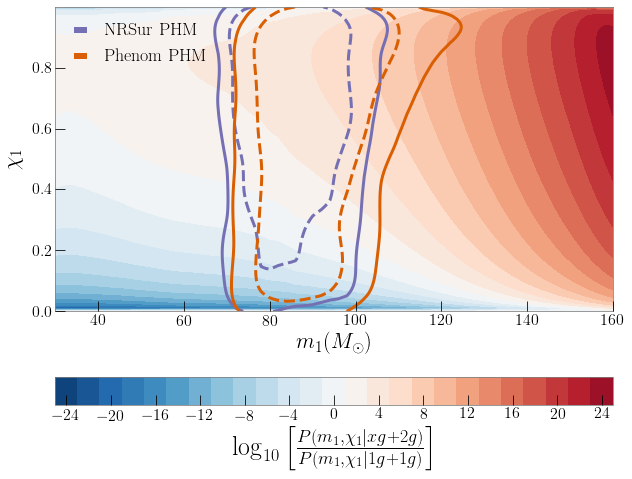

In [7]:
# make the BF figure with both NRSur and Phenom

plt.figure(figsize=(10,8))
ax = plt.subplot(1,1,1)
lines = []
colors=["#7570b3", "#d95f02"]
labels = ['NRSur PHM', 'Phenom PHM']
results = ['gwtc1_plus_no_zero_spin_NRSur','gwtc1_plus_no_zero_spin_IMRPv3HM']
color_dict = dict(zip(results,colors))
label_dict = dict(zip(results,labels))
lw=3

for result in results:
    with open(os.path.join(rdir,result,'full_pe_samples.json'),'r') as f:
        posteriors = json.load(f)
    
    posterior = posteriors[event][-1]['final_samples']
    m_post = posterior['mass_1']
    a_post = posterior['a_1']
    ma_post = [m_post,a_post]

    #Create 2D KDE over M1, A1
    kde_post = stats.gaussian_kde(ma_post)
    Zpost = np.reshape(kde_post(np.vstack([M.ravel(),A.ravel()])).T, M.shape)
    levels90=getCL(Zpost,[0.9])
    levels68=getCL(Zpost,[0.68])

    CS = ax.contour(M,A,Zpost,levels=levels90,colors= color_dict[result],linewidths=lw,zorder=2)
    CS68 = ax.contour(M,A,Zpost,levels=levels68,colors=color_dict[result],linestyles='--',linewidths=lw,zorder=2)

    #Create legend
    lines.append(matplotlib.lines.Line2D([0], [0], color=color_dict[result]))

ax.legend(lines,labels, loc=2,fontsize=18)    
contour= ax.contourf(m1s,a1s,Z, vmin=-24, levels=np.arange(-25,27,2),colors=cmap)
ax.set_xlabel('$m_1 (M_{\odot})$', fontsize=22)
ax.set_ylabel('$\chi_1$',fontsize=22)
cb = plt.colorbar(contour,orientation='horizontal', ticks=list(range(-24,26,4)))
cb.set_label(label=r"$\log_{10} \left[\frac{P(m_1,\chi_1|xg+2g)}{P(m_1,\chi_1|1g+1g)} \right] $",fontsize=26)
ax.set_xlim([30,160])

filename = 'GW190521_Implications_Figures_pdf/hierarchical_bayes_factor.pdf'
plt.savefig(filename,dpi=200)
fig.show()